# Figures for Comprehensive Exam Paper
#### David W. Barker

## Purpose: 
The purpose of this notebook is to put all of the code to create the figures for my comps in one place. My other notebooks have been getting extremely messy. This will focus on the second half of my paper after the exotic models. I may add the exotic models into this notebook later, but as I am a bit pressed for time right now, I'll stick to the figures I have yet to make.

In [ ]:
# Boilerplate

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses
import healpy as hp
from PIL import Image
import matplotlib.animation as animation
from astropy.io import fits
import os
import copy
from pylinex import Fitter, BasisSum, PolynomialBasis, MetaFitter, AttributeQuantity
from pylinex import Basis
from pylinex import TrainedBasis
import pylinex
import py21cmsig
import importlib
import corner
import lochness
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from importlib import reload
from pylinex import RepeatExpander, ShapedExpander, NullExpander,\
    PadExpander, CompiledQuantity, Extractor,  CalculatedQuantity
import spiceypy as spice
from datetime import datetime
import enlighten

# color map for all the plots:
cmap = "viridis"

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

# Imporant constants
NSIDE = 32 # resolution of the map
NPIX = hp.nside2npix(NSIDE)
NPIX   # total number of pixels (size of the array being used)
location = (-23.815,182.25)  # The lat lon location of the moon landing site
spice_kernels = "/home/dbarker7752/lochness/input/spice_kernels/" #location of the spice kernels
frequencies = np.arange(6,50,0.1)

# Cosmological Parameters
H0 = 67.36     # Hubble constant 
h = H0/100     # H0
omM0 = 0.3152   # Omega matter today
omB0 = 0.0493   # Omega baryons today 
omK0 = 0        # Omega curvature today
omC0 = 0.2645   # Omega cold dark matter today 
#omR0 = 8.98e-5  # Omega radiation today
omR0=8.600000001024455e-05  # Omega radiation from 21cm FAST
omL0 = 0.6847   # Omega Dark Energy today

### Boilerplate arrays for healpy (changes with a change in resolution)
thetas = hp.pix2ang(NSIDE,np.arange(NPIX))[0]*(180/np.pi)
phis = hp.pix2ang(NSIDE,np.arange(NPIX))[1]*(180/np.pi)
coordinate_array = np.ones((NPIX,2))
for i in np.arange(NPIX):
    coordinate_array[i] = np.array([phis[i],thetas[i]])

# HASLAM map
gal = perses.foregrounds.HaslamGalaxy()
haslam_data=gal.get_map(39.93) # gets the actual array of the data for that haslam map

# ULSA map 64 bit
ULSA_direction_raw_64 = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/100.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=64,vec=vec,radius=0.1954)
hole_map = copy.deepcopy(ULSA_direction_raw_64[0].data[7])
hole_map[indices] = 10000000
# hp.mollview(ULSA_direction_raw_64[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(hp.nside2npix(64))
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw_64[0].data)
for i,data in enumerate(ULSA_direction_raw_64[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
# hp.mollview(ULSA_min_deadzone[7])

ULSA_direction_64 = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map_64 = ULSA_direction_64    # default galaxy map


# ULSA map 32 bit
ULSA_direction_raw = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/000.fits")
ULSA_frequency = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/210.fits")
ULSA_constant = fits.open("/home/dbarker7752/21_cm_group/ULSA Maps/220.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.1954)
hole_map = copy.deepcopy(ULSA_direction_raw[0].data[7])
hole_map[indices] = 10000000
# hp.mollview(ULSA_direction_raw[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(NPIX)
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw[0].data)
for i,data in enumerate(ULSA_direction_raw[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
# hp.mollview(ULSA_min_deadzone[7])

ULSA_direction = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map = ULSA_direction    # default galaxy map
test_times1 = [[2026,12,22,1,0,0]]   # list of times LOCHNESS will rotate the sky for 
frequency_array = np.array(range(1,51))   # list of frequencies we're evaluating at   

# modifies the galaxy map to not have the CMB (to make it consistent with the delta CMB convention of the signal)
galaxy_map_minCMB = copy.deepcopy(galaxy_map)
redshift_array = 1420.4/frequency_array-1
# This loop creates a CMB subtracted galaxy map to input into LOCHNESS
for i,j in enumerate(redshift_array):
    galaxy_map_minCMB[i] = galaxy_map[i] - py21cmsig.T_gamma(j)
galaxy_map_minCMB[np.where(galaxy_map_minCMB<0.0)] = 0   # Gets rid of the negatives that plague this ULSA map (not sure why they are they)
f = h5py.File("/home/dbarker7752/21_cm_group/foreground_array_minCMB","r")
foreground_array_minCMB = f["foreground_array"]


# radiometer noise
sigT = lambda T_b, dnu, dt: T_b/(np.sqrt(dnu*dt))
# Noise parameters
dnu = 1e6
dt = 1000*3600 # first number is the number of hours of integration time

# Synchrotron Equation
synch = lambda f,A,B,c : A*(f/408)**(B+c*np.log(f/408))  # taken from page 6 of Hibbard et al. 2023 Apj. Arbitrarily chose 25 as my v0

# This identifies the pixels of the absorption region
vec = hp.ang2vec(np.pi/2, 0)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.85)
absorp_map = copy.deepcopy(ULSA_direction[7])
# absorp_map[indices] = 10000000
absorp_indices = indices[np.where(absorp_map[indices] < 1450000)][750:906]
absorp_map[absorp_indices] = 10000000

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]

# frequencies = np.arange(6,50,0.1)
frequencies = np.arange(6,50,0.25)
## RMS ##
#simulation_test = py21cmsig.simulation_run_raw(frequencies,files[0],foreground_array_minCMB,test_times1,dnu,dt,omR0,omM0,omK0,omL0,omB0) # needs to be run to get RMS, that's its only purpose

rms_mean = 0.05
rms_std = 0.009


# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction,7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices = best_foreground_model[10]

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,foreground_array_minCMB[0],7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]

# creates the fiducial Lambda CDM signal
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

# This creates the sky maps that are properly rotated and normalized
beams = np.zeros((len(files),50,NPIX))
beam_euler_angle = [0,90,90]
derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
beam_maps= derp["raw_beam_maps"]

# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams[n][nu] = normalized_beam

f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams","r")
beams = f["normalized_beams"]

beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)

save_path = "/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/" 

# creates a perfect beam that does not distort the foreground at all, just cuts it off at the horizon
data1=(foreground_array_minCMB[0]*beams[1])
test44=np.ones(NPIX)
test44[np.where(data1[49] == 0)] = 0
perfect_beam = test44
perfect_beam_normalized = perfect_beam/perfect_beam.sum()
perfect_beam_normalized.sum()
perfect_beam_array = np.zeros((50,NPIX))
for n in range(50):
    perfect_beam_array[n] = perfect_beam_normalized

# creates a perfect signal that is only adjusted by the horizon
perfect_signal_raw = np.zeros((50))
for n in range(50):
    perfect_signal_raw[n] = np.sum(foreground_array_minCMB[0][n]*perfect_beam_normalized)

pb_interp = scipy.interpolate.CubicSpline(range(1,51),perfect_signal_raw)
perfect_signal = pb_interp(frequencies)

# This creates the sky maps that are properly rotated and normalized 64 bit version. This is loaded in a cell below
# NSIDE = 64 # resolution of the map
# NPIX = hp.nside2npix(NSIDE)
# beams_64 = np.zeros((len(files),50,NPIX))
# beam_euler_angle = [0,90,90]
# derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
# beam_maps= derp["raw_beam_maps"]

# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams_64[n][nu] = normalized_beam

## Loaded in signal training sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]


/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


Prepared Haslam map in 0.15 s.


Prepared Haslam map in 0.141 s.


100%|██████████| 221/221 [00:06<00:00, 34.70it/s]


In [18]:
#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]

### ULSA Galaxy Example and ULSA Galaxy Rotated Example

Text(0.5, 1.0, 'ULSA Galaxy Map at 7 MHz Rotated')

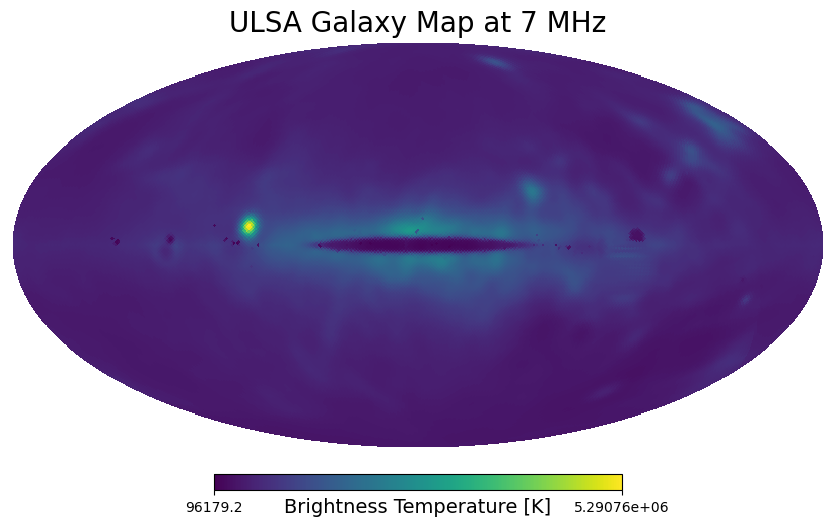

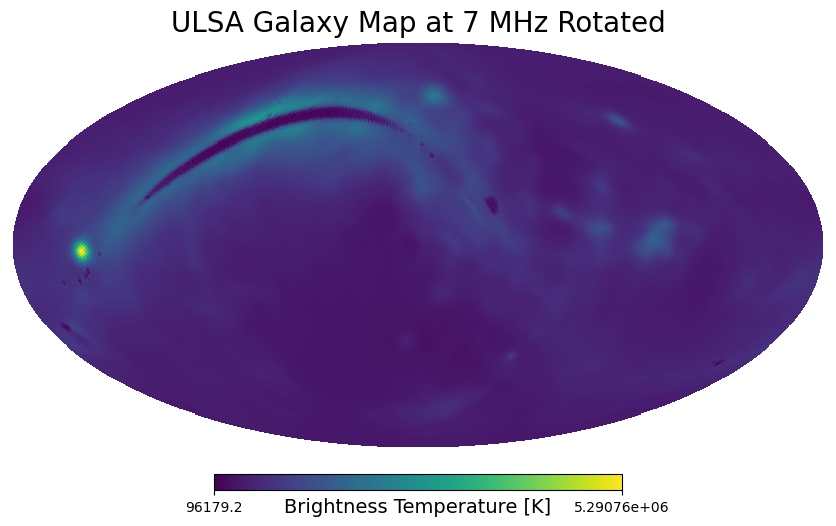

In [4]:
# ULSA Galaxy Example and ULSA Galaxy Rotated Example

# Standard unrotated galaxy
hp.mollview(galaxy_map_64[7],unit="Brightness Temperature [K]",cmap= cmap)
plt.title("ULSA Galaxy Map at 7 MHz" ,fontsize=20)
# plt.savefig(save_path+"ULSA_64bit_Standard")


# ## next few lines create and save the rotated galaxy to save time when loading this up again.
# # galaxy creation part
# # Now we rotate it into a frame consistent with a LuSEE-Night observation window.
# rotated_64_ULSA = lochness.LOCHNESS(spice_kernels,test_times1,location,galaxy_map=galaxy_map_64).lunar_frame_galaxy_maps[0]
# rotated_64_ULSA[np.where(rotated_64_ULSA<0.0)] = 0
# # HDF5 part
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","w")
# hdf5.create_dataset("rotated_sky_maps",data=rotated_64_ULSA)
# hdf5.close()
# ## End of galaxy map creation and hdf5 saving code

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = hdf5["rotated_sky_maps"]
## End of hdf5 loading code

hp.mollview(rotated_64_ULSA[7],min=96179.2,max=5290760,cmap=cmap,unit="Brightness Temperature [K]")
plt.title("ULSA Galaxy Map at 7 MHz Rotated" ,fontsize=20)
# plt.savefig(save_path+"ULSA_64bit_Rotated")

## Five Region Model with Rotated Galaxy
- We'll use the rotated galaxy for examples from here on out since that's the actual foreground we used as our base model.

100%|██████████| 10/10 [00:00<00:00, 5490.65it/s]


Text(0.5, 1.0, 'Five Region Model Rotated')

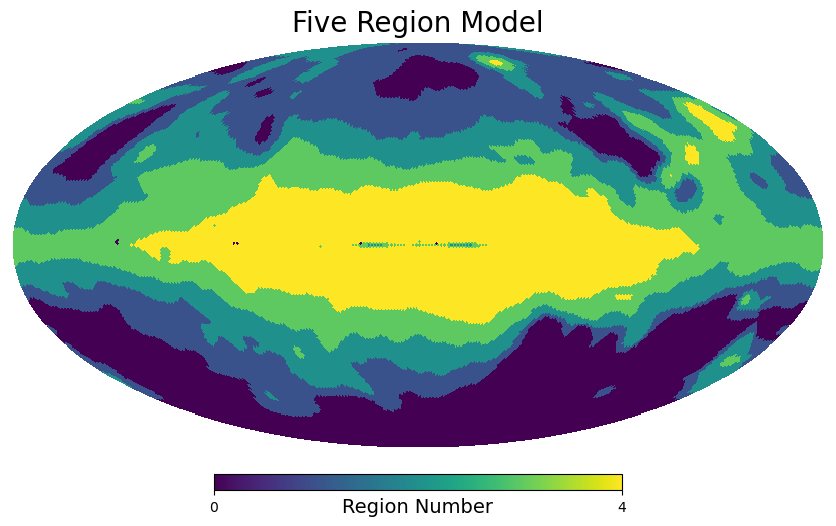

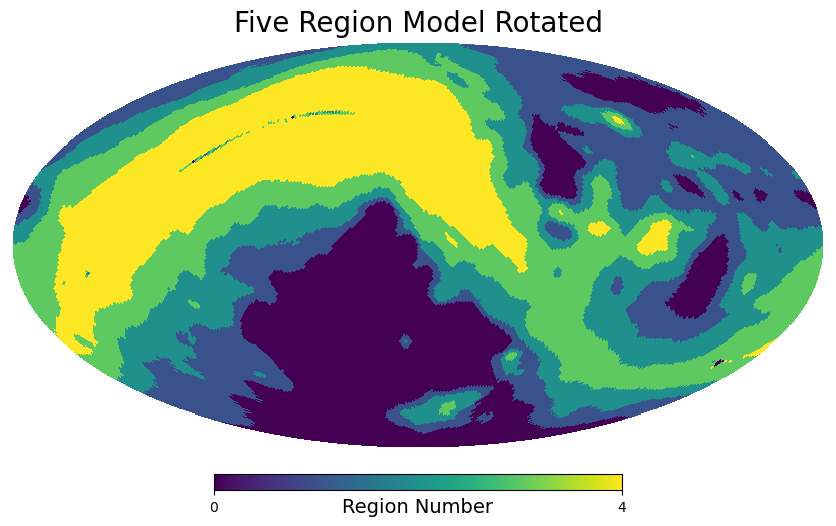

In [5]:
# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction_64,25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices = best_foreground_model[10]
hp.mollview(best_foreground_model[11],unit = "Region Number",cmap=cmap)
plt.title("Five Region Model", fontsize=20)
# plt.savefig(save_path+"five_region_model")

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = hdf5["rotated_sky_maps"]
## End of hdf5 loading code

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,rotated_64_ULSA,25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]
hp.mollview(best_foreground_model_rotated[11],unit = "Region Number")
plt.title("Five Region Model Rotated", fontsize=20)
# plt.savefig(save_path+"five_region_model_rotated")

## Varied Foreground Example

100%|██████████| 2/2 [00:00<00:00, 6803.41it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:01<00:00, 117.74it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 237.26it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 14122.24it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]


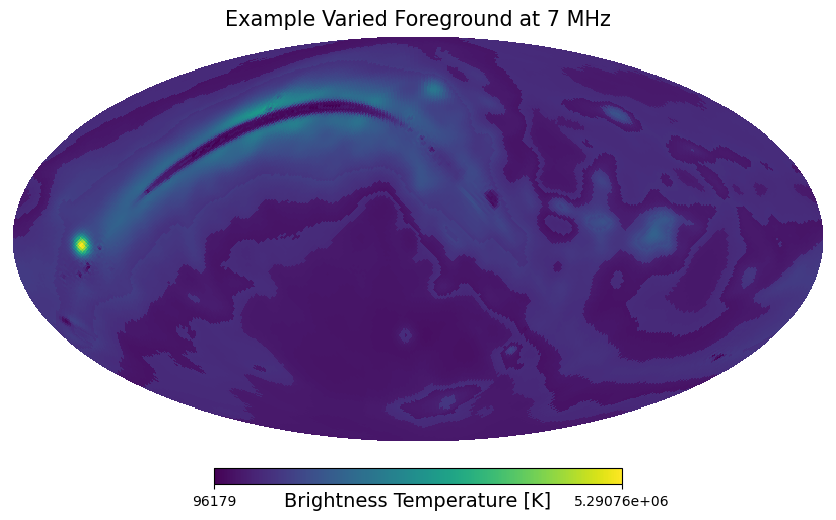

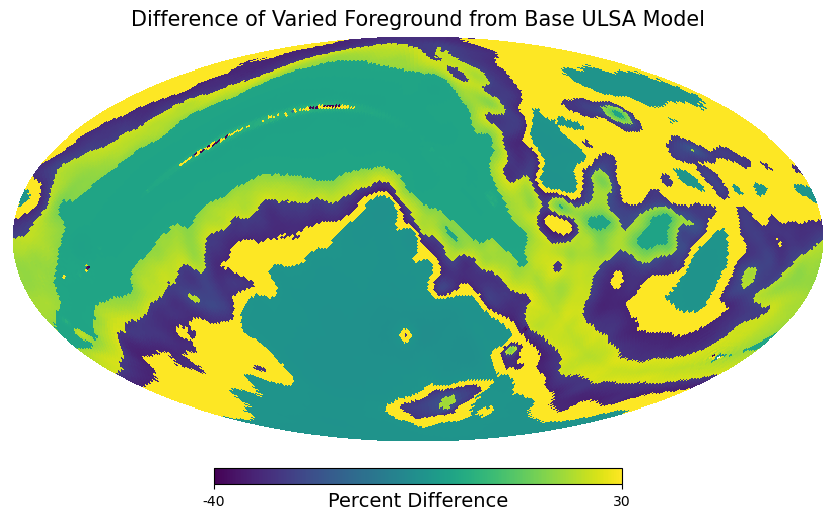

In [ ]:
# Simulation and Training Set for a single LST
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")


# data = simulation_test_beam[0]
# one_sigma_rms = rms_std
# training_set = varied_regolith_training_set_raw
# training_set_parameters = varied_regolith_training_set_raw_params
# signal_extraction_return = signal_extraction(data,rms_mean,rms_std,training_set,training_set_parameters,N=10000,sigma_tolerance=3,iteration_limit=10)


## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = np.array(hdf5["rotated_sky_maps"])
## End of hdf5 loading code

copy_rotated_ULSA = copy.deepcopy(rotated_64_ULSA)
copy_rotated_ULSA[7][region_indices_rotated[0]] += foreground_run_set[5][0][0][4]
copy_rotated_ULSA[7][region_indices_rotated[1]] += foreground_run_set[5][0][1][4]
copy_rotated_ULSA[7][region_indices_rotated[2]] += foreground_run_set[5][0][2][4]
copy_rotated_ULSA[7][region_indices_rotated[3]] += foreground_run_set[5][0][3][4]
copy_rotated_ULSA[7][region_indices_rotated[4]] += foreground_run_set[5][0][4][4]

copy_rotated_ULSA[40][region_indices_rotated[0]] += foreground_run_set[5][100][0][136]
copy_rotated_ULSA[40][region_indices_rotated[1]] += foreground_run_set[5][100][1][136]
copy_rotated_ULSA[40][region_indices_rotated[2]] += foreground_run_set[5][100][2][136]
copy_rotated_ULSA[40][region_indices_rotated[3]] += foreground_run_set[5][100][3][136]
copy_rotated_ULSA[40][region_indices_rotated[4]] += foreground_run_set[5][100][4][136]

hp.mollview(copy_rotated_ULSA[7],unit="Brightness Temperature [K]",min=96179, max= 5290760,cmap=cmap )
plt.title("Example Varied Foreground at 7 MHz", fontsize=15)
# plt.savefig(save_path+"example_foreground_trainingset_7MHz")
hp.mollview((copy_rotated_ULSA[7]-rotated_64_ULSA[7])/rotated_64_ULSA[7]*100,min=-40,max=30,unit="Percent Difference",cmap=cmap)
plt.title("Difference of Varied Foreground from Base ULSA Model" ,fontsize = 15)
# plt.savefig(save_path+"example_fgts_diff")

## Varied Foreground Training Set Distribution

100%|██████████| 176/176 [00:00<00:00, 208.98it/s]


[[1.  1. ]
 [3.4 3.4]
 [4.6 4.6]]


100%|██████████| 2/2 [00:00<00:00, 12.42it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 10994.24it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]


100%|██████████| 10/10 [00:00<00:00, 4883.91it/s]


Text(0, 0.5, 'Percent Difference from ULSA Base')

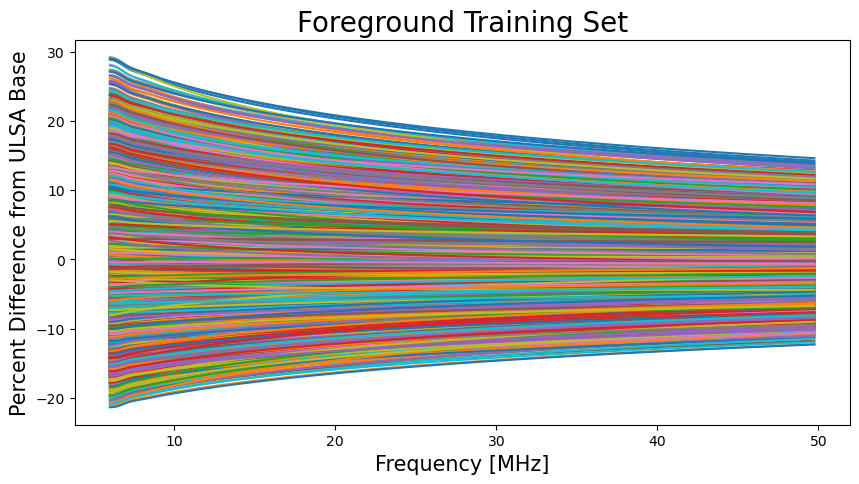

In [15]:

## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 10000
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

## This portion creates the foreground training set
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)

best_foreground_model_rotated_32 = py21cmsig.make_foreground_model(np.arange(5,51),5,foreground_array_minCMB[0],25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated_32 = best_foreground_model_rotated_32[10]
# Let's weight each region correctly:
masked_indices = np.where(beams[0][-1] <= 0)[0]
masked_region_indices = {}
for r in region_indices_rotated_32:  # Creates list of indices per region that exist within the beam
    ones_array = np.ones(NPIX)
    ones_array[masked_indices] = 0
    zeros_array = np.zeros(NPIX)
    zeros_array[region_indices_rotated_32[r]] = 1
    masked_region_indices[r] = np.where(ones_array*zeros_array == 1)

region_1_weight = masked_region_indices[0][0].shape[0]/(NPIX/2)
region_2_weight = masked_region_indices[1][0].shape[0]/(NPIX/2)
region_3_weight = masked_region_indices[2][0].shape[0]/(NPIX/2)
region_4_weight = masked_region_indices[3][0].shape[0]/(NPIX/2)
region_5_weight = masked_region_indices[4][0].shape[0]/(NPIX/2)
region_weights = np.array((region_1_weight,region_2_weight,region_3_weight,region_4_weight,region_5_weight))
region_weights

foreground_training_set = np.zeros((N,len(frequencies)))
for n in range(N):
    new_T = 0
    for r in range(5):
        new_T += foreground_run_set[5][n][r]*region_weights[r]
    foreground_training_set[n] = perfect_signal + new_T

# Displays a training set of ONLY the foregrounds. No beam weights.

plt.figure(figsize=(10, 5))

for n in range(10000):
    plt.plot(frequencies, (foreground_training_set[n]-perfect_signal)/perfect_signal*100)
plt.title("Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference from ULSA Base",fontsize="15")
# plt.savefig(save_path+"Foreground_Training_Set")

## Beam Example

Text(0.5, 1.0, 'Beam-weighted Foreground at 40 MHz')

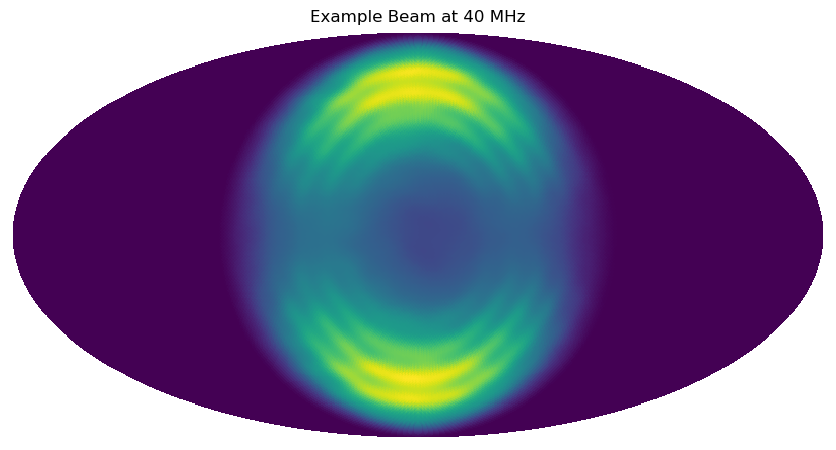

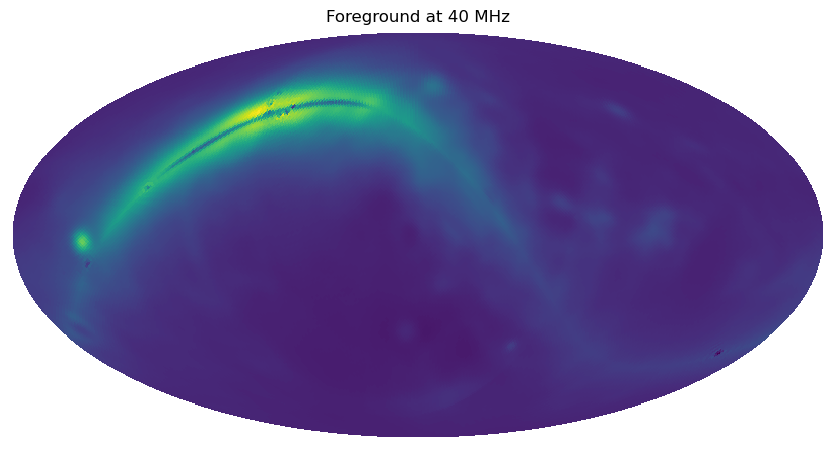

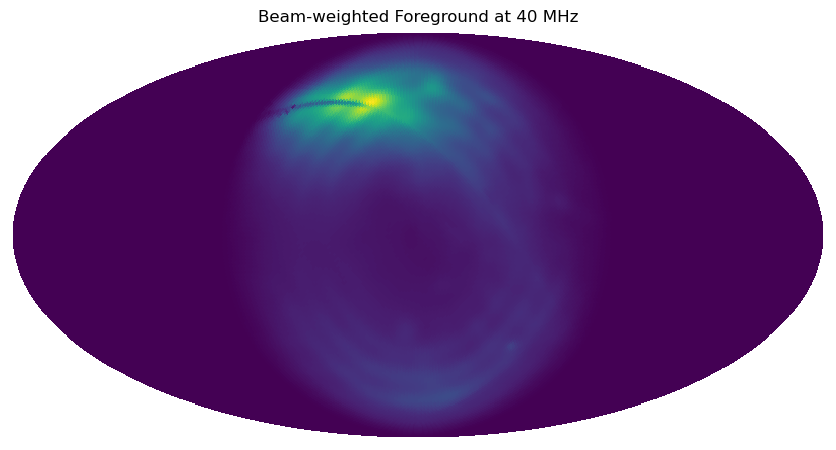

In [16]:
# This creates the sky maps that are properly rotated and normalized 64 bit version
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
beams_64 = np.zeros((len(files),50,NPIX))
beam_euler_angle = [0,90,90]
derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
beam_maps= derp["raw_beam_maps"]

### Creates an h5py file for 64 bit normalized beams
# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams_64[n][nu] = normalized_beam
# f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams_64","w")
# f.create_dataset("normalized_beams",data=beams_64)
# f.close()
### End hdf5 creation code

### Loads hdf5 for normalized beams
f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams_64","r")
beams_64 = f["normalized_beams"]
### End loading code 

hp.mollview(beams_64[0][40], cbar=False,cmap=cmap)
plt.title("Example Beam at 40 MHz")
# plt.savefig(save_path+"Example_Beam_40MHz")

# And now to weight it with the foreground
# First a foreground without a colorbar:
hp.mollview(rotated_64_ULSA[40],cbar=False,cmap=cmap)
plt.title("Foreground at 40 MHz")
# plt.savefig(save_path+"ULSA_rot_40MHz_nocbar")

# now beam_weighted:
hp.mollview(rotated_64_ULSA[40]*beams_64[0][40], cbar=False,cmap=cmap)
plt.title("Beam-weighted Foreground at 40 MHz")
# plt.savefig(save_path+"ULSA_40MHz_beam-weighted")

## Beam Training Set

100%|██████████| 176/176 [00:03<00:00, 52.25it/s]


[[1.  2. ]
 [3.3 3.5]
 [4.2 4.7]]


100%|██████████| 10000/10000 [00:00<00:00, 97466.93it/s]


[0, 0, 0]


100%|██████████| 2/2 [00:00<00:00, 5472.02it/s]


[[ 1.59202418e+01  1.59202418e+01 -2.65279830e+00 -2.65279830e+00
  -1.37293590e-02 -1.37293590e-02]
 [ 1.66130589e+01  1.66130589e+01 -2.69062579e+00 -2.69062579e+00
  -1.47582387e-02 -1.47582387e-02]
 [ 1.89769800e+01  1.89769800e+01 -2.68235795e+00 -2.68235795e+00
  -1.34495335e-02 -1.34495335e-02]
 [ 2.42115565e+01  2.42115565e+01 -2.66682587e+00 -2.66682587e+00
  -1.20169084e-02 -1.20169084e-02]
 [ 5.22431891e+01  5.22431891e+01 -2.65055339e+00 -2.65055339e+00
  -2.42275191e-02 -2.42275191e-02]]


Text(0, 0.5, 'Percent Difference from ULSA Base')

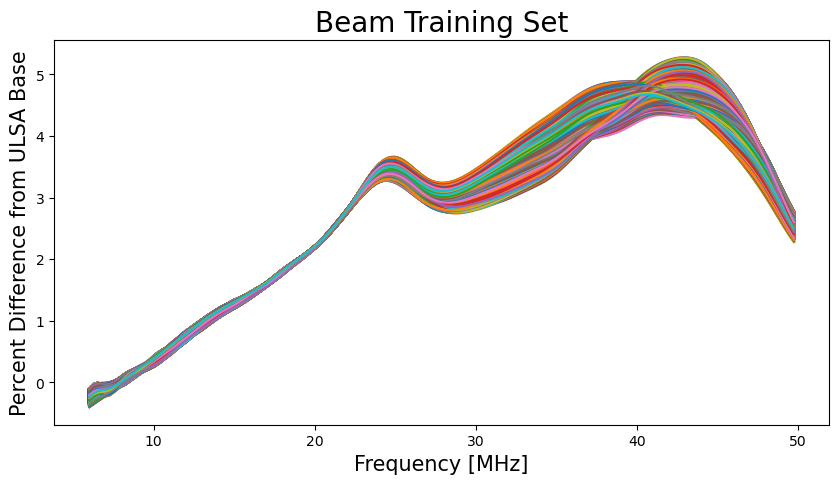

In [17]:

## Creates a training set with varied beams:

custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0,0,0]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 10000 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

# Beam Training Set

plt.figure(figsize=(10, 5))

beam_training_set=foreground_run_set[3]

# Displays a training set of the beams weighting the ULSA base model.
for n in range(10000):
    plt.plot(frequencies, (beam_training_set[n]-perfect_signal)/perfect_signal*100)
plt.title("Beam Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference from ULSA Base",fontsize="15")
# plt.savefig(save_path+"Beam_Training_Set")

100%|██████████| 176/176 [00:01<00:00, 165.93it/s]


[[1.  2. ]
 [3.3 3.5]
 [4.2 4.7]]


100%|██████████| 500/500 [00:02<00:00, 185.31it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 8603.70it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]


Text(0, 0.5, 'Percent Difference from ULSA Base')

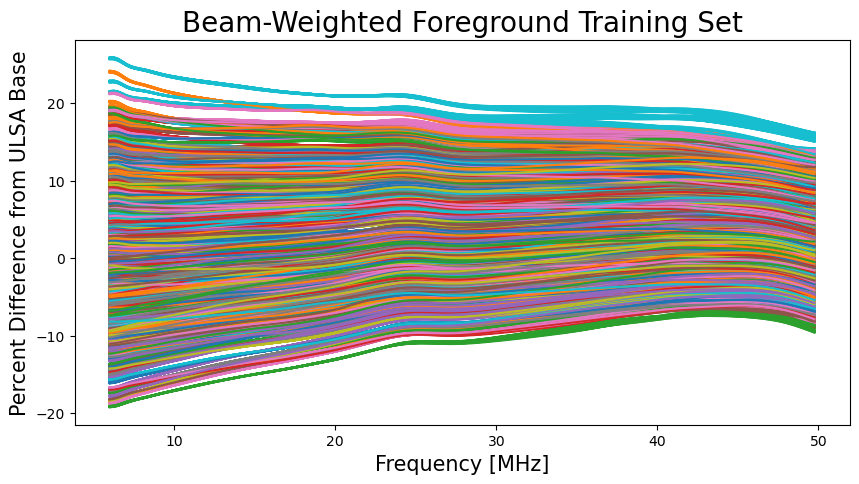

In [18]:
## Creates a training set with varied beams:

custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                              # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

plt.figure(figsize=(10, 5))
# Beam-Weighted Foreground Training Set
beam_foreground_training_set=foreground_run_set[3]

# Displays a training set of the beams weighting the ULSA base model.
for n in range(20000):
    plt.plot(frequencies, (beam_foreground_training_set[n]-perfect_signal)/perfect_signal*100)
plt.title("Beam-Weighted Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference from ULSA Base",fontsize="15")
# plt.savefig(save_path+"Beam_Foreground_Training_Set")

## PYLINEX flow-chart figures (at least the ones we haven't already made)

In [ ]:
# Lambda CDM Training Set
# plt.figure(figsize=(10, 5))
# for n in range(10000):
#     plt.plot(frequencies,labmdaCDM_training_set[n])
# plt.title("Lambda CDM Signal Training Set",fontsize=20)
# plt.ylabel(r"$\delta T_b$",fontsize=15)
# plt.xlabel("Frequency [MHz]",fontsize=15)
# plt.savefig(save_path+"Lambda_CDM_Training_Set")

Text(0.5, 0, 'Frequency [MHz]')

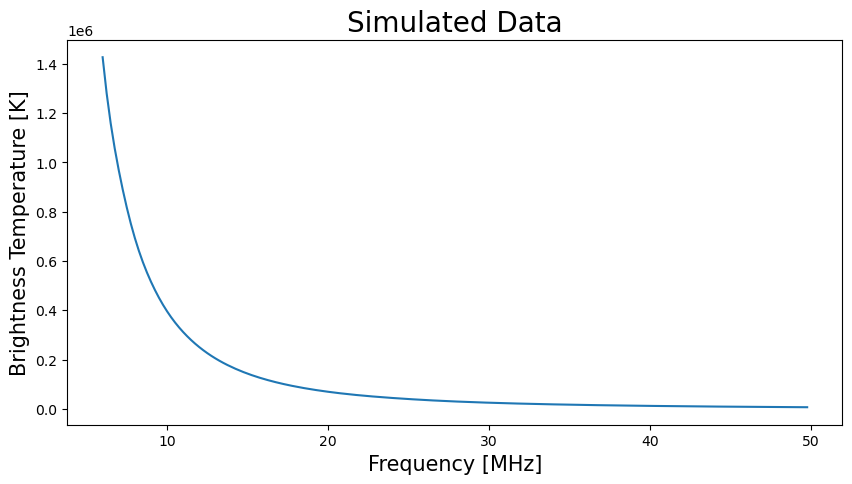

In [19]:
# Simulation Data

plt.figure(figsize=(10, 5))
plt.plot(frequencies, simulation_test_beam[0])
plt.title("Simulated Data",fontsize=20)
plt.ylabel("Brightness Temperature [K]",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)
# plt.savefig(save_path+"Simulated_Signal")


In [9]:



## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
parameter_variation = [0.0000005,0.00000025,0.0000005]                           # For making a random foreground

rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)


print(fg_range_array)

#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = labmdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=30,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,30)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter2.sizes['Foreground']
num_signal_terms = fitter2.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter2.chi_squared} Chi Squared")
print(f"{fitter2.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")




100%|██████████| 2/2 [00:00<00:00, 5105.67it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:01<00:00, 148.57it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60001 ]]


100%|██████████| 500/500 [00:02<00:00, 215.36it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 2/2 [00:00<00:00, 7169.75it/s]


[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.42275312e-02]]
[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.422

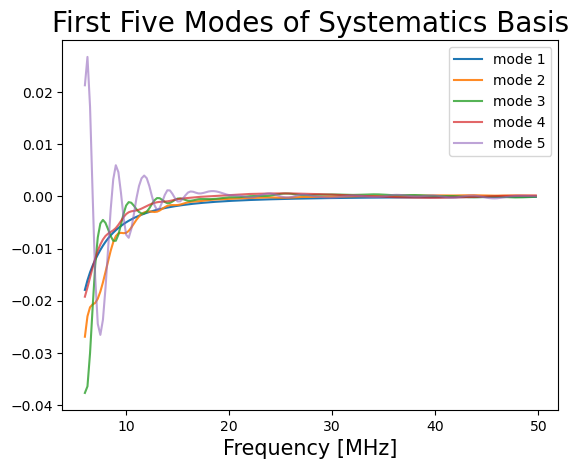

In [21]:

# Plots the foreground basis
for n in range(5):
    plt.plot(frequencies, foreground_basis.basis[n],label=f"mode {n+1}",alpha = 1-0.1*n)
plt.title("First Five Modes of Systematics Basis",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"Foreground_Basis")

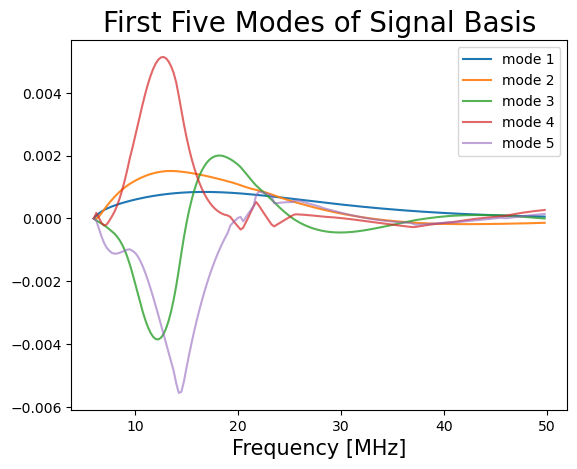

In [22]:
# Plots the foreground basis
for n in range(5):
    plt.plot(frequencies, signal_basis.basis[n],label=f"mode {n+1}",alpha = 1-0.1*n)
plt.title("First Five Modes of Signal Basis",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"Signal_Basis")

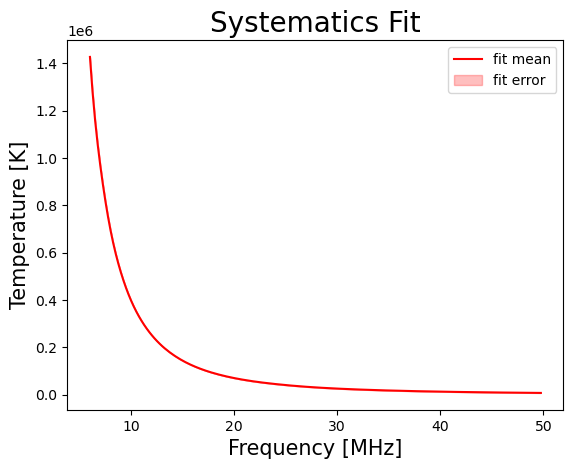

In [23]:
plt.plot(frequencies, fitter2.subbasis_channel_mean("Foreground"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Foreground")+fitter2.subbasis_channel_error("Foreground"),fitter2.subbasis_channel_mean("Foreground")-fitter2.subbasis_channel_error("Foreground"),label="fit error",alpha=0.25,color="red")
plt.title("Systematics Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"example_foreground_fit")

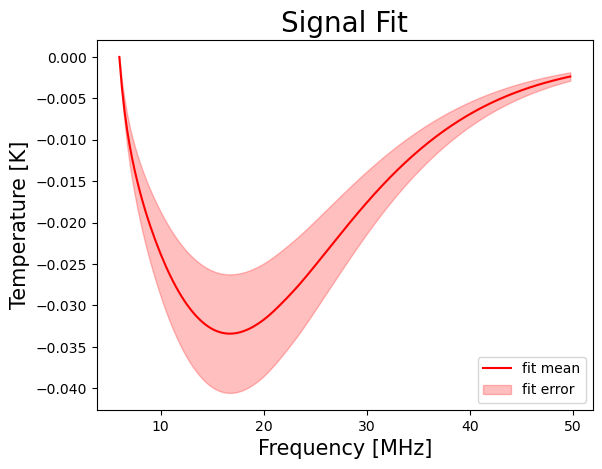

In [24]:
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"example_signal_fit")

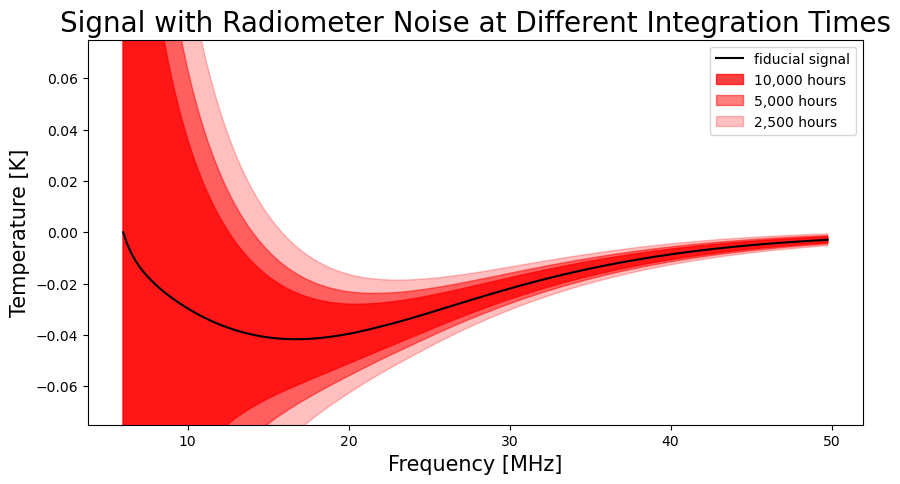

In [ ]:
# This is a noise figure for Jack, but might include this in my paper near the noise section...maybe

plt.figure(figsize=(10, 5))
plt.plot(frequencies, simulation_test_beam[1],label = "fiducial signal", c="black")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],dnu,10000*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],dnu,10000*3600),label="10,000 hours",alpha=0.75,color="red")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],dnu,5000*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],dnu,5000*3600),label="5,000 hours",alpha=0.5,color="red")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],dnu,2500*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],dnu,2500*3600),label="2,500 hours",alpha=0.25,color="red")
plt.title("Signal with Radiometer Noise at Different Integration Times",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.ylim(-0.075,0.075)
plt.legend()

plt.savefig("Multi_error_signal_for_Jack")


In [25]:
# Noise levels from various integration times at 17 MHz
sig_10=sigT(simulation_test_beam[0],dnu,10000*3600)[43]
sig_5=sigT(simulation_test_beam[0],dnu,5000*3600)[43]
sig_2dot5=sigT(simulation_test_beam[0],dnu,2500*3600)[43]
print(sig_10)
print(sig_5)
print(sig_2dot5)

0.01807425279839379
0.025560853437248364
0.03614850559678758


## Training Set Curve Number Optimization Test (Ready to Cook)
- Takes a long time to run, so I'll save it for last
- I would also like to add STD in a fill between for the graph

In [ ]:

## Creates the bases 5 times and compares the results.
iterations = 1 # number of basis to average per value
N_vectors = 20
bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
average_diff = np.zeros((iterations-1))


# values = [1000000]
# # values = [51,100000]
# average_diff_num_foreground = np.zeros((3,len(values)))
# for i,N in enumerate (values):
#     # numbers for the training sets
#     Nb = int(np.sqrt(N))
#     Nfg = int(np.sqrt(N))
#     # Nb = 100
#     # Nfg = 10000
#     Ns = N
#     for b in tqdm(range(iterations)):
#         pbar = manager.counter(total=iterations, desc='Iterations')
#     #### Pylinex Fit #####

#         custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
#         parameter_variation = [0.0000005,0.00000025,0.0000005]                              # For making a random foreground
#         rms_mean = 0.05
#         rms_std = 0.009
#         ## Interpolate the varied beams to match the rest of the data
#         varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
#         for n in range(len(varied_regolith_training_set_raw)):
#             beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#             varied_regolith_training_set[n] = beam_regolith_interp(frequencies)

#         exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                                     custom_parameter_range,show_parameter_ranges=True)
#         n_regions = 5
#         reference_frequency = 25
#         sky_map = foreground_array_minCMB[0]
#         BTS_curves = exp_test[0]
#         BTS_params = exp_test[1]
#         beam_sky_training_set = beams[:,5:,:]
#         beam_sky_training_set_params = varied_regolith_training_set_raw_params
#         raw_beam_weighted_sky_maps = raw_sky_maps

#         # parameter_variation = [0.05,0.025,0.05]
#         determine_parameter_range = True
#         new_FG_parameter_mean = None
#         foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                             beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation,B_value_functions,\
#                                                 define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
#         rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
#         new_parameter_mean = np.zeros((n_regions,3))
#         fg_range_array = np.zeros((n_regions,6))
#         foreground_parameter_variation = np.array(parameter_variation)
#         for r in range(n_regions):
#             new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#             # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#             fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#             fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#             fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#             fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#             fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#             fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]

#         fg_training_set = foreground_run_set[3]
#         noise_level = sigT(sim_data,dnu,dt)
#         foreground_training_set_array = copy.deepcopy(fg_training_set)
#         foreground_basis_2 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)


# # ### This takes quite some time to run, so let's save these numbers

# # ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data","w")
# hdf5.create_dataset("average_difference_foreground",data=average_diff_num_foreground)
# hdf5.close()
# # ### End of HDF5 data saving


# ## Now the loop for each exotic signal training set
values=[10000]
# # lambda CDM
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
# values = [10000]
# average_diff_num_lambdaCDM = np.zeros((3,len(values)))
# for i,N in enumerate (values):
#     # numbers for the training sets
#     Nb = int(np.sqrt(N))
#     Nfg = int(np.sqrt(N))
#     # Nb = 100
#     # Nfg = 10000
#     Ns = N
#     for b in tqdm(range(iterations)):
#         pbar = manager.counter(total=iterations, desc='Iterations')
#         signal_training_set_lambdaCDM=py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,N)
#         signal_training_set = signal_training_set_lambdaCDM[0]
#         noise_level = sigT(sim_data,dnu,dt)
#         signal_training_set_array = copy.deepcopy(signal_training_set)
#         signal_basis_CDM2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set2","w")
# hdf5.create_dataset("training_set",data=signal_training_set_lambdaCDM[0])
# hdf5.create_dataset("parameters",data=signal_training_set_lambdaCDM[1])
# hdf5.close()
### End of HDF5 data saving
N = 10000
# DMAN
parameters_DMAN = [[2*10e-22,1*10e-22,5*10e-23,2*10e-23,5*10e-24,2*10e-24]]
bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
average_diff = np.zeros((iterations-1))
average_diff_num_DMAN = np.zeros((3,len(values)))

pbar = manager.counter(total=iterations, desc='Iterations')
DMAN_training_set=py21cmsig.DMAN_training_set(frequencies,parameters_DMAN,N)


### This takes quite some time to run, so let's save these numbers

### HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_training_set","w")
hdf5.create_dataset("training_set",data=DMAN_training_set[0])
hdf5.create_dataset("parameters",data=DMAN_training_set[1])
hdf5.close()
### End of HDF5 data saving

# DMD
bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
average_diff = np.zeros((iterations-1))
parameters_DMD = [[0.5*10e26, 1*10e26, 3*10e26, 10*10e26, 30*10e26, 100*10e26, 500*10e26]]
average_diff_num_DMD = np.zeros((3,len(values)))

DMD_training_set=py21cmsig.DMD_training_set(frequencies,parameters_DMD,N)


### This takes quite some time to run, so let's save these numbers

### HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_training_set","w")
hdf5.create_dataset("training_set",data=DMD_training_set[0])
hdf5.create_dataset("parameters",data=DMD_training_set[1])
hdf5.close()
### End of HDF5 data saving

# MCDM
bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
average_diff = np.zeros((iterations-1))
parameters_MCDM = [[0.1,0.5,2,5,10]]
average_diff_num_MCDM = np.zeros((3,len(values)))

MCDM_training_set = py21cmsig.MCDM_training_set(frequencies,parameters_MCDM,N)


### This takes quite some time to run, so let's save these numbers

### HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_training_set","w")
hdf5.create_dataset("training_set",data=MCDM_training_set[0])
hdf5.create_dataset("parameters",data=MCDM_training_set[1])
hdf5.close()
### End of HDF5 data saving

# EDE
bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
average_diff = np.zeros((iterations-1))
parameters_EDE = np.array([[2e-5,4e-5],[50,100]])
average_diff_num_EDE = np.zeros((3,len(values)))

EDE_training_set = py21cmsig.EDE_training_set(frequencies,parameters_EDE,N)


### This takes quite some time to run, so let's save these numbers

### HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_training_set","w")
hdf5.create_dataset("training_set",data=EDE_training_set[0])
hdf5.create_dataset("parameters",data=EDE_training_set[1])
hdf5.close()
### End of HDF5 data saving

# ERB
bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
average_diff = np.zeros((iterations-1))
parameters_ERB = np.array([[0.1,10,375],[25,100,200]])
average_diff_num_ERB = np.zeros((3,len(values)))

ERB_training_set = py21cmsig.ERB_training_set(frequencies,parameters_ERB,N)


### This takes quite some time to run, so let's save these numbers

### HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_training_set","w")
hdf5.create_dataset("training_set",data=ERB_training_set[0])
hdf5.create_dataset("parameters",data=ERB_training_set[1])
hdf5.close()
### End of HDF5 data saving


### HDF5 data loading
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data","r")
# average_diff_num_foreground=hdf5["average_difference_foreground"]
### End of HDF5 data loading

## Subtracts the first basis from the other 4 and averages the result:

plt.figure(figsize=(10, 5))
plt.plot(average_diff_num[0][1][1:9], average_diff_num[0][0][1:9]  ,label = "beam-weighted foreground")
plt.plot(average_diff_num[0][1][1:9], average_diff_num[1][0][1:9]  ,label = "signal")
plt.title("Basis Test",fontsize=20)
plt.xlabel("Number of Training Set Curves",fontsize="15")
plt.ylabel("Average Maximum Difference Among Modes",fontsize="12")
plt.xscale("log")
plt.legend()
plt.savefig(save_path+"basis_test")

  2%|▏         | 179/10000 [00:10<09:54, 16.51it/s]


KeyboardInterrupt: 

In [ ]:
Nsel = 50 # The index to go to for your selection of the training sets
ERB_training_set_selection = py21cmsig.ERB_training_set(frequencies,parameters_ERB,N)[0]
signal_training_set = ERB_training_set
noise_level = sigT(sim_data,dnu,dt) 
signal_training_set_array = copy.deepcopy(signal_training_set)
signal_basis = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

array([[2.94735840e-02, 2.78578267e-02, 2.46141038e-02, 2.99325096e-02,
        2.93865189e-02, 2.86669955e-02, 2.18360984e-02, 2.44129015e-02,
        3.23558504e-02, 2.70576262e-02],
       [6.82608829e-03, 6.40788396e-03, 6.04804019e-03, 7.25369552e-03,
        6.43426933e-03, 5.51083518e-03, 6.15018630e-03, 5.23979048e-03,
        4.58206538e-03, 6.17620355e-03],
       [5.00000000e+01, 1.00000000e+02, 2.50000000e+02, 5.00000000e+02,
        7.50000000e+02, 1.00000000e+03, 2.50000000e+03, 5.00000000e+03,
        7.50000000e+03, 1.00000000e+04]])

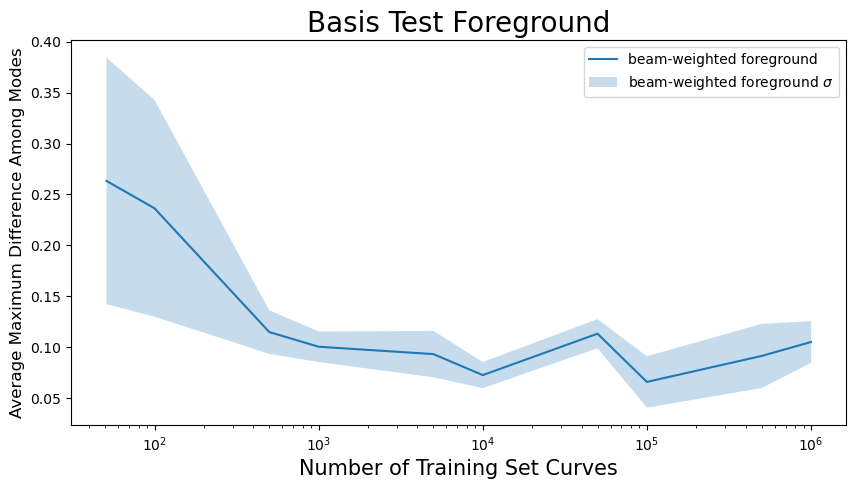

In [947]:
plt.figure(figsize=(10, 5))
plt.plot(average_diff_num_foreground[2], average_diff_num_foreground[0]  ,label = "beam-weighted foreground")
plt.fill_between(average_diff_num_foreground[2], average_diff_num_foreground[0]+average_diff_num_foreground[1]  ,\
    average_diff_num_foreground[0]-average_diff_num_foreground[1]  ,label = r"beam-weighted foreground $\sigma$",alpha=0.25)
plt.title("Basis Test Foreground",fontsize=20)
plt.xlabel("Number of Training Set Curves",fontsize="15")
plt.ylabel("Average Maximum Difference Among Modes",fontsize="12")
plt.xscale("log")
plt.legend()
plt.savefig(save_path+"basis_test_fg_not_using")

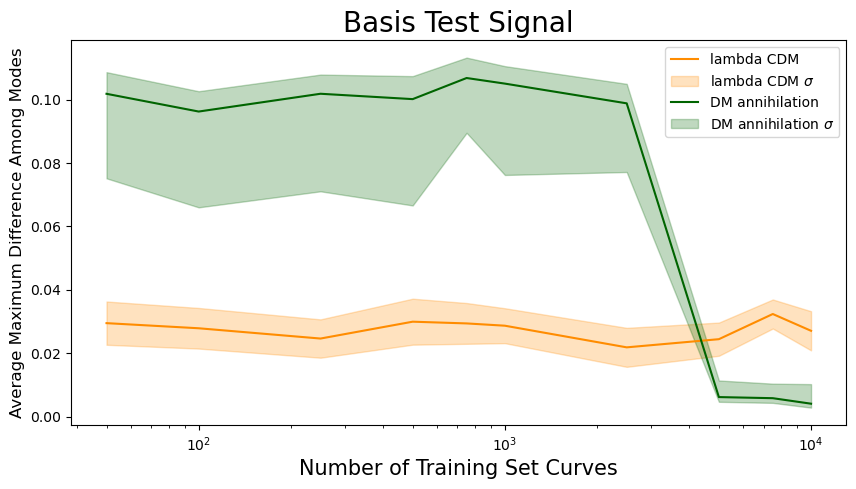

In [946]:
plt.figure(figsize=(10, 5))
plt.plot(average_diff_num_lambdaCDM[2], average_diff_num_lambdaCDM[0]  ,label = "lambda CDM",color="darkorange")
plt.fill_between(average_diff_num_lambdaCDM[2], average_diff_num_lambdaCDM[0]+average_diff_num_lambdaCDM[1],\
    average_diff_num_lambdaCDM[0]-average_diff_num_lambdaCDM[1]  ,label = r"lambda CDM $\sigma$",alpha=0.25,color="darkorange")
plt.plot(average_diff_num_DMAN[2], average_diff_num_DMAN[0]  ,label = "DM annihilation",color="darkgreen")
plt.fill_between(average_diff_num_DMAN[2], average_diff_num_DMAN[0]+average_diff_num_lambdaCDM[1],\
    average_diff_num_DMAN[0]-average_diff_num_DMAN[1]  ,label = r"DM annihilation $\sigma$",alpha=0.25,color="darkgreen")
plt.title("Basis Test Signal",fontsize=20)
plt.xlabel("Number of Training Set Curves",fontsize="15")
plt.ylabel("Average Maximum Difference Among Modes",fontsize="12")
plt.xscale("log")
plt.legend()
plt.savefig(save_path+"basis_test_signals_not_using")

## Example Signal Extraction

  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10369.11it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:01<00:00, 154.15it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60001 ]]


100%|██████████| 500/500 [00:02<00:00, 220.88it/s]


[5e-07, 2.5e-07, 5e-07]


100%|██████████| 2/2 [00:00<00:00, 10965.50it/s]


[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.42275312e-02]]
[[ 1.59202338e+01  1.59202498e+01 -2.65279764e+00 -2.65279897e+00
  -1.37293521e-02 -1.37293658e-02]
 [ 1.66130506e+01  1.66130672e+01 -2.69062512e+00 -2.69062646e+00
  -1.47582313e-02 -1.47582461e-02]
 [ 1.89769705e+01  1.89769894e+01 -2.68235727e+00 -2.68235862e+00
  -1.34495268e-02 -1.34495402e-02]
 [ 2.42115444e+01  2.42115686e+01 -2.66682520e+00 -2.66682654e+00
  -1.20169024e-02 -1.20169144e-02]
 [ 5.22431630e+01  5.22432152e+01 -2.65055273e+00 -2.65055405e+00
  -2.42275070e-02 -2.422

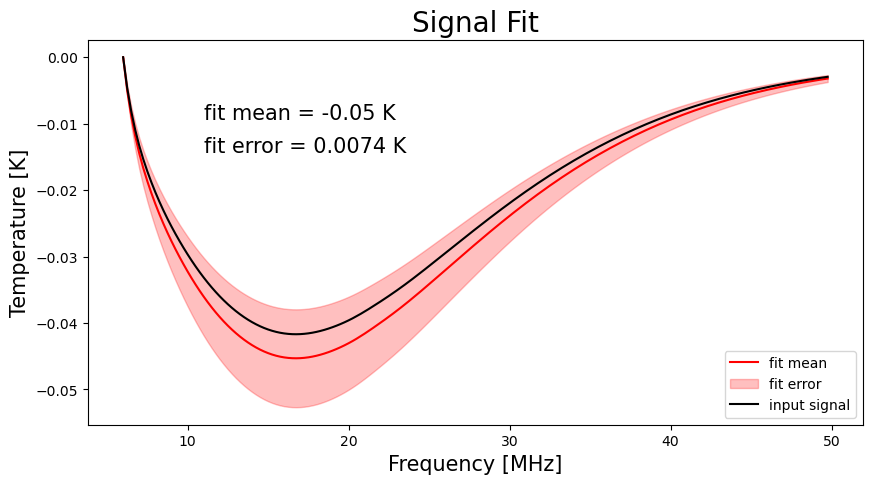

In [ ]:



## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
parameter_variation = [0.0000005,0.00000025,0.0000005]                           # For making a random foreground

rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)


print(fg_range_array)

#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = labmdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=30,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,30)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter2.sizes['Foreground']
num_signal_terms = fitter2.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter2.chi_squared} Chi Squared")
print(f"{fitter2.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")

plt.figure(figsize=(10, 5))
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.legend()
plt.savefig(save_path+"Example_extraction")

## Bias (Going to Need to Cook)


In [48]:
# # # This creates your 100 random beam-weighted foregrounds
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground

# # signal_model = signal_model_set[signal][Nsim*i+nsim]

# ## Interpolate the varied beams to match the rest of the data
# varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
# for n in range(len(varied_regolith_training_set_raw)):
#     beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#     varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
# Nb = 10 # number of beams in the beam training set
# exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                             custom_parameter_range,show_parameter_ranges=False)

# BTS_curves = exp_test[0]
# BTS_params = exp_test[1]
# beam_sky_training_set = beams[:,5:,:]
# beam_sky_training_set_params = varied_regolith_training_set_raw_params
# raw_beam_weighted_sky_maps = raw_sky_maps
# Nfg = 10
# determine_parameter_range = True
# new_FG_parameter_mean = None
# foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                     beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                         define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)

# # plots the 100 random bwfg
# for n in range(100):
#     plt.plot((foreground_run[3][n]-simulation_test_beam[0])/simulation_test_beam[0])

# new_parameter_mean = np.zeros((n_regions,3))
# fg_range_array_random_10 = np.zeros((n_regions,6))
# foreground_parameter_variation = np.array(parameter_variation)
# for r in range(n_regions):
#     new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#     # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#     fg_range_array_random_10[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#     fg_range_array_random_10[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


###This creates a training set for each of the randomly created beam-weighted foregrounds

# HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","w")
# hdf5.create_dataset("beam_weighted_curves",data=foreground_run[3])
# hdf5.create_dataset("beam_weighted_parameters",data=foreground_run[4])
# hdf5.close()
# # End of HDF5 data saving
# Nb = 10
# Nfg=10
# # ## HDF5 loading of 100 bw foreground
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weighted_curves"]
curves_100_params = hdf5["beam_weighted_parameters"]
# ## HDF5 loading end

# custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
# custom_parameter_range_variation = [0.000025, 0.00001,0.00001]
# parameter_variation = [0.0000005,0.00000025,0.0000005]  

# custom_parameter_range_array = np.zeros((Nb,3,2))
# foreground_means = np.zeros((Nfg,n_regions,3))
# for n in range(Nfg):
#     for r in range(n_regions):
#         foreground_means[n][r] = curves_100_params[n][r*3:r*3+3]

# for n in range(Nb):
#     custom_parameter_range_array[n]=[[curves_100_params[n*Nfg][15]-curves_100_params[n*Nfg][15]*custom_parameter_range_variation[0],curves_100_params[n*Nfg][15]+curves_100_params[n*Nfg][15]*custom_parameter_range_variation[0]],\
#                                 [curves_100_params[n*Nfg][16]-curves_100_params[n*Nfg][16]*custom_parameter_range_variation[1],curves_100_params[n*Nfg][16]+curves_100_params[n*Nfg][16]*custom_parameter_range_variation[1]],\
#                                 [curves_100_params[n*Nfg][17]-curves_100_params[n*Nfg][17]*custom_parameter_range_variation[2],curves_100_params[n*Nfg][17]+curves_100_params[n*Nfg][16]*custom_parameter_range_variation[2]]]

# dt = 10000*3600  # integration time
# N = 10000  # number of curves in the training set
# curves_100_training_sets = np.zeros((Nb*Nfg,N,len(frequencies)))
# curves_100_training_set_parameters = np.zeros((Nb*Nfg,N,len(foreground_run[4][0])))

# for nb,beam_params in enumerate(custom_parameter_range_array):
#     for nfg,mean in enumerate(foreground_means):
# ## Creates a foreground for the simulation:

#     # For making a random foreground

#     ## Interpolate the varied beams to match the rest of the data
#         custom_parameter_range = beam_params
#         parameter_variation = [0.0000005,0.00000025,0.0000005] 
#         varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
#         for n in range(len(varied_regolith_training_set_raw)):
#             beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#             varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
#         Nb = int(np.sqrt(N)) # number of beams in the beam training set
#         exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                                     custom_parameter_range,show_parameter_ranges=False)

#         BTS_curves = exp_test[0]
#         BTS_params = exp_test[1]
#         beam_sky_training_set = beams[:,5:,:]
#         beam_sky_training_set_params = varied_regolith_training_set_raw_params
#         raw_beam_weighted_sky_maps = raw_sky_maps
#         Nfg = int(np.sqrt(N))
#         determine_parameter_range = False
#         new_FG_parameter_mean = mean
#         foreground_run_ts = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                             beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                                 define_parameter_mean=True,parameter_mean=new_FG_parameter_mean)

#         # new_parameter_mean = np.zeros((n_regions,3))
#         # fg_range_array = np.zeros((n_regions,6))
#         # foreground_parameter_variation = np.array(parameter_variation)
#         # for r in range(n_regions):
#         #     new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#         #     # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#         #     fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#         #     fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#         #     fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#         #     fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#         #     fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#         #     fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]

#         curves_100_training_sets[nfg+len(foreground_means)*nb] = foreground_run_ts[3]
#         curves_100_training_set_parameters[nfg+len(foreground_means)*nb] = foreground_run_ts[4]

# HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims_ts","w")
# hdf5.create_dataset("curves_training_set",data=curves_100_training_sets)
# hdf5.create_dataset("curves_training_set_parameters",data=curves_100_training_set_parameters)
# hdf5.close()
## End of HDF5 data saving

## HDF5 loading of 100 bw foreground training sets (10,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims_ts","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
## HDF5 loading end

# Curves array is shaped as follows:
# one entry per signal model (1 fiducial + 5 exotic)
# one entry per varied simulation (Nsim)
# 5 entries for different data: 0: full simulation, 1: only the signal, 2: only the foreground, 3: only the noise, 4: simulation without noise
# then the frequency array

Nsim = 1000
signal_models = ["lambdaCDM","DMAN","DMD","EDE","ERB","MCDM"]
signal_model_set = {"lambdaCDM": lambdaCDM_training_set, "DMAN": DMAN_training_set, "DMD": DMD_training_set, "EDE": EDE_training_set, "ERB": ERB_training_set, "MCDM": MCDM_training_set}
signal_parameter_set = {"lambdaCDM": lambdaCDM_training_set_params, "DMAN": DMAN_training_set_params, "DMD": DMD_training_set_params, "EDE": EDE_training_set_params, "ERB": ERB_training_set_params, "MCDM": MCDM_training_set_params}
simulation_curves_array = np.zeros((Nsim*len(signal_models),5,len(frequencies))) 
simulation_parameters_array = {}

# these expanded curves make working with the signal models a bit easier
curves_100_expanded = curves_100
for n in range(9):   # NOT GENERAL only works because we have 10 times as many singal models as foreround models
        curves_100_expanded = np.concatenate((curves_100_expanded,curves_100),axis=0)

curves_100_params_expanded = curves_100_params
for n in range(9):   # NOT GENERAL only works because we have 10 times as many singal models as foreround models
        curves_100_params_expanded = np.concatenate((curves_100_params_expanded,curves_100_params),axis=0)

for i,signal in enumerate(signal_models): 
    for nsim,bwfg,par in zip(range(Nsim),curves_100_expanded,curves_100_params_expanded):
        signal_model = signal_model_set[signal][Nsim*i+nsim]
        foreground_for_sim = bwfg
        parameters_for_sim = par

# Our simulation function
        simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

        simulation_curves_array[Nsim*i+nsim][0] = simulation_test_beam[0]
        simulation_curves_array[Nsim*i+nsim][1] = simulation_test_beam[1]
        simulation_curves_array[Nsim*i+nsim][2] = simulation_test_beam[2]
        simulation_curves_array[Nsim*i+nsim][3] = simulation_test_beam[3]
        simulation_curves_array[Nsim*i+nsim][4] = simulation_test_beam[4]

        simulation_parameters_array[Nsim*i+nsim] = {"bwfg": parameters_for_sim, "signal": signal_parameter_set[signal][Nsim*i+nsim]}


Nsim_tot = len(simulation_curves_array)
bias_scores = np.zeros((Nsim_tot))

for n in tqdm(range (Nsim_tot)):
#### Pylinex Fit #####
        foreground_training_set_array = curves_100_training_sets[n % 100]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
        signal_model_number = n // 1000  # Only works when you have 1000 signals of the same model
        print(signal_model_number)
        model = signal_models[signal_model_number]
        sig_training_set = signal_model_set[model]
        IC = "DIC"
        sim = simulation_curves_array[n]
        sim_data = sim[0]
        noise_level = sigT(sim_data,dnu,dt)
        foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
        signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
        temperatures = sim_data
        basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
        quantity = AttributeQuantity(IC)
        dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
        # priors = {"Signal_prior" : signal_basis.gaussian_prior}
        meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
        fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
        bias_scores[n] = fitter2.bias_statistic/len(frequencies)
        

        

        # print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
        # print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
        # print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
        # print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
        # # print(f"{fitter2.log_evidence} log evidence")
        # print(f"{fitter2.chi_squared} Chi Squared")
        # print(f"{fitter2.psi_squared} Psi Squared")
        # pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
        # print(f"True {pearsonr}")

        # plt.figure(figsize=(10, 5))
        # plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
        # plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
        # plt.title("Signal Fit",fontsize=20)
        # plt.xlabel("Frequency [MHz]",fontsize="15")
        # plt.ylabel("Temperature [K]",fontsize="15")
        # plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
        # plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
        # plt.plot(frequencies,sim[1],label="input signal",c="black")
        # plt.legend()
        # plt.savefig(save_path+"Example_extraction")


  0%|          | 1/6000 [00:00<18:37,  5.37it/s]

0
Minimizing DIC over grid.
0


  0%|          | 3/6000 [00:00<18:32,  5.39it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 5/6000 [00:00<17:23,  5.74it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 7/6000 [00:01<17:28,  5.72it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 9/6000 [00:01<16:51,  5.92it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 11/6000 [00:01<16:39,  5.99it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 13/6000 [00:02<17:10,  5.81it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 15/6000 [00:02<16:24,  6.08it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 17/6000 [00:02<16:51,  5.91it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.


  0%|          | 18/6000 [00:03<15:46,  6.32it/s]

0
Minimizing DIC over grid.
0


  0%|          | 20/6000 [00:03<15:59,  6.23it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 22/6000 [00:03<16:43,  5.96it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 24/6000 [00:04<16:11,  6.15it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 26/6000 [00:04<16:15,  6.12it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 28/6000 [00:04<14:49,  6.72it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  0%|          | 30/6000 [00:04<14:33,  6.83it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 32/6000 [00:05<14:28,  6.87it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 34/6000 [00:05<14:13,  6.99it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 36/6000 [00:05<14:15,  6.97it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 38/6000 [00:06<14:20,  6.93it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 40/6000 [00:06<14:30,  6.85it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 42/6000 [00:06<15:20,  6.47it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 44/6000 [00:07<15:06,  6.57it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 46/6000 [00:07<14:56,  6.64it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 48/6000 [00:07<14:38,  6.77it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 50/6000 [00:07<14:05,  7.04it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 52/6000 [00:08<14:24,  6.88it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 54/6000 [00:08<14:18,  6.93it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 56/6000 [00:08<13:54,  7.13it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 58/6000 [00:09<13:49,  7.16it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 60/6000 [00:09<13:46,  7.19it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 62/6000 [00:09<14:28,  6.84it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 64/6000 [00:09<15:45,  6.28it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 66/6000 [00:10<15:35,  6.34it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 68/6000 [00:10<17:00,  5.81it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 70/6000 [00:10<17:22,  5.69it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 72/6000 [00:11<15:46,  6.26it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|          | 74/6000 [00:11<15:30,  6.37it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|▏         | 76/6000 [00:11<15:46,  6.26it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|▏         | 78/6000 [00:12<15:24,  6.41it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|▏         | 80/6000 [00:12<16:04,  6.14it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|▏         | 82/6000 [00:12<15:08,  6.51it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|▏         | 84/6000 [00:13<15:03,  6.55it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|▏         | 86/6000 [00:13<16:20,  6.03it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  1%|▏         | 87/6000 [00:13<16:33,  5.95it/s]

Minimizing DIC over grid.
0


  1%|▏         | 88/6000 [00:13<17:57,  5.48it/s]

Minimizing DIC over grid.
0


  2%|▏         | 90/6000 [00:14<18:15,  5.40it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 92/6000 [00:14<17:15,  5.71it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 94/6000 [00:14<15:30,  6.34it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 96/6000 [00:15<15:20,  6.41it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 98/6000 [00:15<15:16,  6.44it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 100/6000 [00:15<14:39,  6.71it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 102/6000 [00:16<14:43,  6.67it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 104/6000 [00:16<14:23,  6.83it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 106/6000 [00:16<14:56,  6.57it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 108/6000 [00:17<15:22,  6.39it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 110/6000 [00:17<15:28,  6.34it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 112/6000 [00:17<15:00,  6.54it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 114/6000 [00:17<14:30,  6.76it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 116/6000 [00:18<13:56,  7.03it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 118/6000 [00:18<13:33,  7.23it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 120/6000 [00:18<13:44,  7.13it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 122/6000 [00:19<13:46,  7.11it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 124/6000 [00:19<13:33,  7.22it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 126/6000 [00:19<14:12,  6.89it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 128/6000 [00:19<14:22,  6.80it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 130/6000 [00:20<14:39,  6.67it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 132/6000 [00:20<15:30,  6.31it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 134/6000 [00:20<15:02,  6.50it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 135/6000 [00:21<16:25,  5.95it/s]

Minimizing DIC over grid.
0


  2%|▏         | 137/6000 [00:21<16:57,  5.76it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 139/6000 [00:21<15:31,  6.29it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 141/6000 [00:22<15:19,  6.37it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 143/6000 [00:22<14:43,  6.63it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 145/6000 [00:22<15:22,  6.35it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 147/6000 [00:22<15:39,  6.23it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  2%|▏         | 149/6000 [00:23<16:04,  6.07it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  3%|▎         | 151/6000 [00:23<16:09,  6.03it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  3%|▎         | 153/6000 [00:24<16:41,  5.84it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  3%|▎         | 155/6000 [00:24<16:32,  5.89it/s]

Minimizing DIC over grid.
0
Minimizing DIC over grid.
0


  3%|▎         | 156/6000 [00:24<15:17,  6.37it/s]


Minimizing DIC over grid.
0


KeyboardInterrupt: 

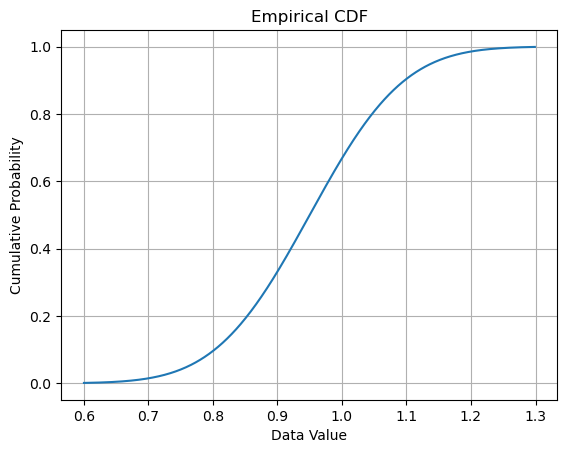

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data
CDF = scipy.stats.norm.cdf(np.arange(0.6,1.3,0.001),0.95,0.115)


# Plot the CDF
plt.plot(np.arange(0.6,1.3,0.001),data)
plt.xlabel('Data Value')
plt.ylabel('Cumulative Probability')
plt.title('Empirical CDF')
plt.grid(True)
plt.show()

Text(0.5, 0, 'Bias Score')

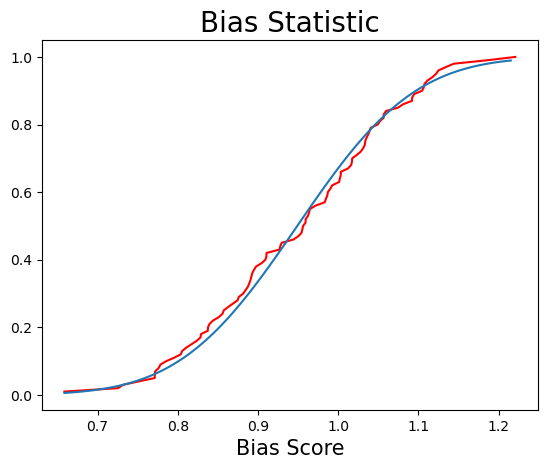

In [91]:
# plt.figure(figsize=(5, 5))
data = bias_scores[0:100]
data.sort()
std=data.std()
mean=data.mean()
the_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
CDF = scipy.stats.norm.cdf(the_range,mean,std)
cdf_values = np.arange(1, len(data) + 1) / len(data)
plt.plot
plt.plot(data, cdf_values,label = "fit mean", c="red")
plt.plot(the_range,CDF)
plt.title("Bias Statistic",fontsize=20)
plt.xlabel("Bias Score",fontsize="15")
# plt.ylabel("Temperature [K]",fontsize="15")
# plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
# plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
# plt.legend()
# plt.savefig(save_path+"Example_extraction")

In [90]:
np.arange(data.min(),data.max(),(data.max()-data.min())/len(data)).shape

(100,)

TypeError: 'numpy.float64' object cannot be interpreted as an integer

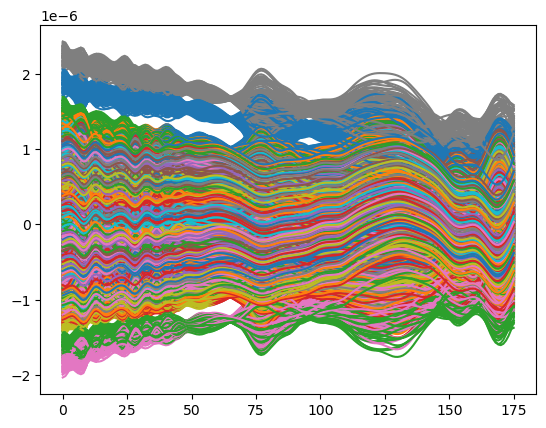

In [938]:
N = 99
for n in range(10000):
    plt.plot((curves_100_training_sets[N][n]-curves_100[N])/curves_100[N])

In [927]:
curves_100[0]

array([1415613.0114612 , 1268967.02048515, 1148135.0679947 ,
       1046958.59974942,  959277.82930472,  879928.77274089,
        807736.48280787,  742531.23756548,  684150.67604979,
        632316.90378055,  586270.67752434,  545131.21122946,
        508016.94651832,  474153.55609205,  443197.83122922,
        414914.72211283,  389069.50102077,  365432.56356957,
        343794.04358572,  323949.20567701,  305693.51984193,
        288837.34606609,  273250.14209033,  258816.30024896,
        245420.37937872,  232955.50300968,  221348.48074158,
        210534.24061982,  200447.40700949,  191025.1374281 ,
        182215.62530314,  173969.91532319,  166239.1263529 ,
        158977.20070693,  152149.1845024 ,  145722.94034188,
        139666.37696669,  133949.77955104,  128552.76208379,
        123457.15892864,  118644.68871892,  114097.13109766,
        109796.8718831 ,  105726.50456793,  101868.6731999 ,
         98207.00813642,   94728.94573759,   91422.88753053,
         88277.25243276,

In [871]:
fitter2.bias_statistic/np.sqrt(176)

11.443921986622701

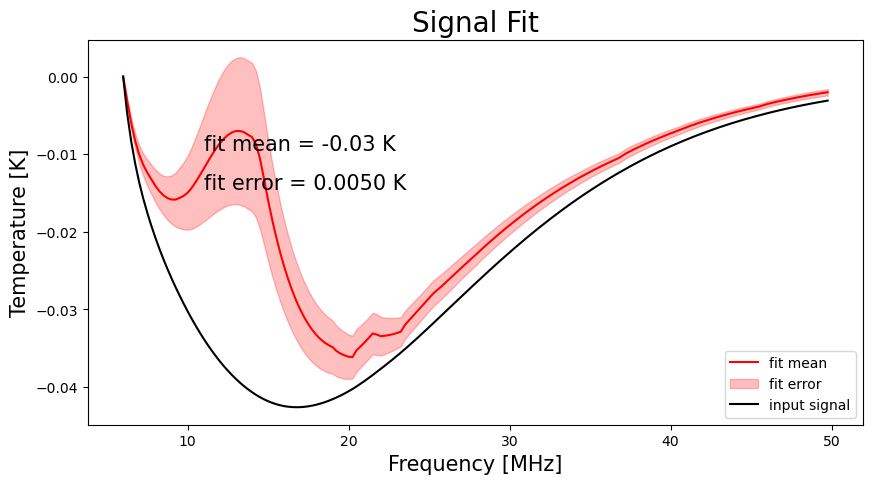

In [870]:
plt.figure(figsize=(10, 5))
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,sim[1],label="input signal",c="black")
plt.legend()
plt.savefig(save_path+"Example_extraction")

In [859]:
curves_100_expanded[199]

array([1195290.5532331 , 1072474.65701766,  972139.40659766,
        888685.43714739,  816412.73489649,  750537.11161573,
        690189.33329473,  635443.70343721,  586333.74482287,
        542739.40307756,  504031.74280356,  469441.24351549,
        438182.18949241,  409565.7242922 ,  383333.09129122,
        359326.55617079,  337380.53091998,  317321.15456144,
        298961.80452282,  282107.72853575,  266558.52659538,
        252132.70584365,  238739.94272876,  226311.46713224,
        214776.76986579,  204064.94765243,  194107.7954591 ,
        184835.72272153,  176176.8487439 ,  168064.20907673,
        160457.11684923,  153321.45453647,  146622.91256858,
        140328.11971676,  134407.90678898,  128833.68241124,
        123576.32339492,  118608.67460873,  113912.87512037,
        109472.99423136,  105272.63491081,  101295.81005536,
         97529.5091506 ,   93961.34568583,   90578.76336798,
         87369.38059986,   84321.93878422,   81425.2391021 ,
         78667.82900075,

In [778]:
labmdaCDM_training_set.shape

(10000, 176)

In [768]:
n =5679
num = n % 100
num

79

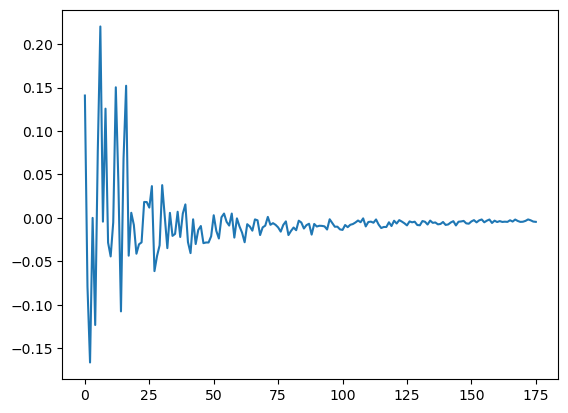

In [756]:
plt.plot(simulation_curves_array[130][0]-curves_100[30])

In [686]:
curves_100_training_set_parameters[40][99]

array([ 1.52282670e+01, -2.71239546e+00, -1.35364311e-02,  1.70834559e+01,
       -2.74866735e+00, -1.54225394e-02,  1.91086024e+01, -2.66593015e+00,
       -1.36242470e-02,  2.38231018e+01, -2.65109476e+00, -1.17498863e-02,
        5.18806547e+01, -2.60490923e+00, -2.32504256e-02,  2.54878287e+00,
        4.05312315e+00,  4.50102840e+00])

In [687]:
curves_100_params[40]

array([ 1.52282660e+01, -2.71239519e+00, -1.35364342e-02,  1.70834562e+01,
       -2.74866718e+00, -1.54225383e-02,  1.91085993e+01, -2.66593003e+00,
       -1.36242440e-02,  2.38231083e+01, -2.65109473e+00, -1.17498856e-02,
        5.18806381e+01, -2.60490967e+00, -2.32504226e-02,  2.54881440e+00,
        4.05311966e+00,  4.50099025e+00])

In [661]:
custom_parameter_range_array

array([[[1.55743694, 1.55751481],
        [3.74422858, 3.74430346],
        [3.9485986 , 3.94867553]],

       [[2.94257526, 2.94272239],
        [3.97194654, 3.97202598],
        [4.76712571, 4.7672131 ]],

       [[1.53770887, 1.53778576],
        [3.44900112, 3.4490701 ],
        [4.79405373, 4.79413616]],

       [[2.82577642, 2.82591771],
        [3.40949054, 3.40955873],
        [4.3113011 , 4.3113783 ]],

       [[2.54875068, 2.54887812],
        [4.05307913, 4.05316019],
        [4.50094524, 4.50103078]],

       [[0.73090277, 0.73093932],
        [4.01525388, 4.01533418],
        [4.42756174, 4.42764617]],

       [[0.9685543 , 0.96860273],
        [3.54889116, 3.54896214],
        [4.19662078, 4.19669824]],

       [[1.95347741, 1.95357509],
        [3.81465281, 3.81472911],
        [4.35476903, 4.35485072]],

       [[2.43845631, 2.43857824],
        [3.81948433, 3.81956072],
        [4.40336685, 4.40344908]],

       [[2.20163805, 2.20174814],
        [4.03628625, 4.0363669

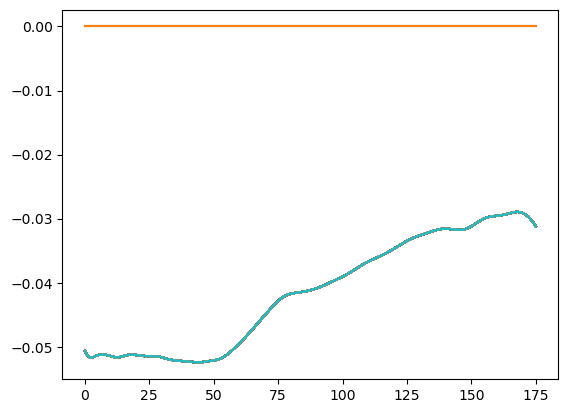

In [681]:
h=60
for n in range(100):
    plt.plot((curves_100_training_sets[h][n]-curves_100[1])/curves_100[1])
plt.plot(sigT(curves_100[h],dnu,dt)/curves_100[h]*10)
plt.plot(-sigT(curves_100[h],dnu,dt)/curves_100[h]*10)

In [588]:
curves_100_params[0]

array([1435554.591845  , 1287769.51690622, 1165860.18955594,
       1063689.19002872,  975126.07603135,  895028.751481  ,
        822190.98060621,  756391.98924378,  697412.85024571,
        644933.02854367,  598220.87419797,  556442.58575721,
        518765.11383254,  484447.95440238,  453119.36065391,
        424501.28220979,  398317.18618585,  374307.17765428,
        352273.51731627,  332033.249963  ,  313402.76553653,
        296208.04665313,  280315.31920191,  265601.11650523,
        251942.18508831,  239224.89515532,  227373.53182339,
        216321.9090765 ,  206003.90805436,  196356.54431002,
        187329.13693811,  178873.98995422,  170943.31903173,
        163491.6308263 ,  156482.91391141,  149883.68966519,
        143660.64332445,  137783.08606186,  132230.33154054,
        126984.12280387,  122026.13960593,  117338.14936759,
        112902.44771691,  108701.45211252,  104717.56506361,
        100934.16194671,   97338.53858248,   93918.93994939,
         90663.57742953,

In [551]:
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weithed_curves"]
curves_100_params = hdf5["beam_weithed_parameters"]

KeyError: "Unable to synchronously open object (object 'beam_weithed_parameters' doesn't exist)"

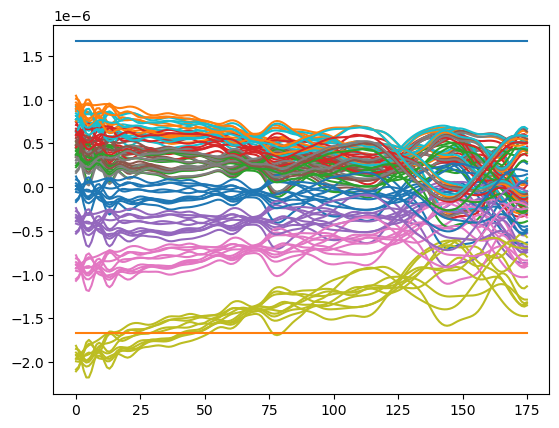

In [537]:
for n in range(100):
    plt.plot((foreground_run[3][n]-curves_100[99])/curves_100[99])
    # plt.plot((curves_100[99]-simulation_test_beam[0])/simulation_test_beam[0])
plt.plot((sigT(curves_100[99],dnu,dt))/curves_100[99]*10)
plt.plot((-sigT(curves_100[99],dnu,dt))/curves_100[99]*10)

In [534]:
sigT(curves_100[99],dnu,dt)

array([0.21490959, 0.1928234 , 0.17468972, 0.15954985, 0.14643516,
       0.13453179, 0.12367016, 0.11383826, 0.10502008, 0.09717869,
       0.09020395, 0.08396608, 0.07833374, 0.07319098, 0.06848744,
       0.06418845, 0.06025852, 0.05666223, 0.05336676, 0.05033957,
       0.04754766, 0.04496101, 0.04256272, 0.04033898, 0.03827565,
       0.0363588 , 0.03457609, 0.03291545, 0.03136465, 0.02991239,
       0.02855148, 0.02727578, 0.02607909, 0.02495531, 0.02389881,
       0.02290403, 0.02196535, 0.02107767, 0.02023807, 0.01944418,
       0.01869359, 0.01798379, 0.01731211, 0.01667579, 0.01607204,
       0.01549826, 0.01495271, 0.01443386, 0.01394015, 0.01347007,
       0.01302241, 0.01259602, 0.01218972, 0.01180235, 0.01143296,
       0.01108061, 0.0107444 , 0.01042336, 0.01011648, 0.0098227 ,
       0.00954102, 0.00927051, 0.00901056, 0.00876062, 0.00852014,
       0.0082886 , 0.0080656 , 0.00785077, 0.0076437 , 0.007444  ,
       0.00725123, 0.00706492, 0.00688461, 0.00670986, 0.00654

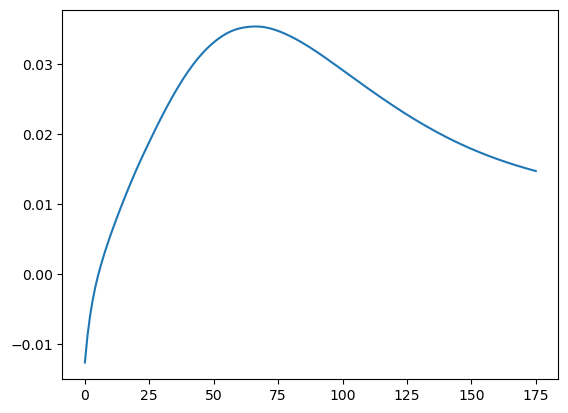

In [411]:
plt.plot(simulation_curves_array[4][1]-simulation_curves_array[1][1])

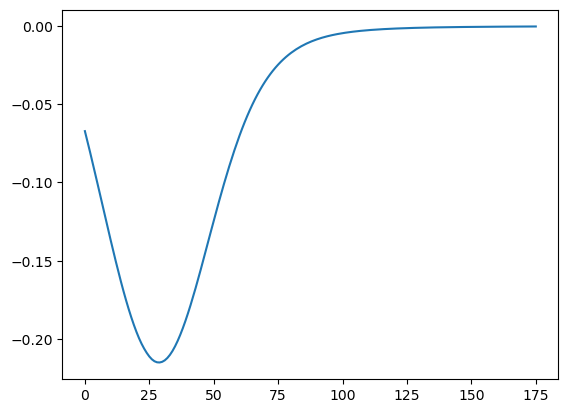

In [380]:
plt.plot(simulation_curves_array[5][0][1])